<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_11/s11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download our code repository and install python dependencies

In [1]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull
!git clone "https://github.com/jyanivaddi/dl_hub.git"
!git pull
!pip install torchinfo
!pip install prettytable
!pip install torch_lr_finder

Cloning into 'ERA_V1'...
remote: Enumerating objects: 901, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 901 (delta 35), reused 20 (delta 5), pack-reused 821
Receiving objects: 100% (901/901), 14.52 MiB | 16.04 MiB/s, done.
Resolving deltas: 100% (480/480), done.
fatal: not a git repository (or any of the parent directories): .git
Cloning into 'dl_hub'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 58 (delta 22), reused 43 (delta 13), pack-reused 0
Receiving objects: 100% (58/58), 13.07 KiB | 4.36 MiB/s, done.
Resolving deltas: 100% (22/22), done.
fatal: not a git repository (or any of the parent directories): .git


Add all the imports:

In [2]:
from __future__ import print_function
import sys
sys.path.append("ERA_V1/session_11")
sys.path.append("dl_hub")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from dl_hub.main import setup_model,build_model
from dl_hub.utils.utils import model_summary, get_incorrect_predictions
from dl_hub.utils.vis_utils import show_incorrect_predictions, plot_statistics, plot_losses, plot_accuracy, plot_lr_values


/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Define Albumentations image augmentations. We use RandomResizedCrop, HorizontalFlip, and cutout

In [3]:
train_transforms = A.Compose(
    [
        AA.crops.transforms.RandomResizedCrop(height = 32,width = 32,p=0.2),
        A.HorizontalFlip(p=0.2),
        AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1, max_height=8,
                                                max_width=8, min_holes = 1,
                                                min_height=8, min_width=8,
                                                fill_value=(0.491, 0.482, 0.447),
                                                mask_fill_value = None),

        A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
        ToTensorV2(),
    ]
)
test_transforms = A.Compose([

    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
    ToTensorV2(),
])

In [4]:
optimizer_type = 'SGD'
optimizer_params = {
    'weight_decay': 5e-4,
    'lr': 0.01,
    'momentum': 0.9
}
scheduler_type = 'ReduceLrOnPlateau'
scheduler_params = {
    'mode': 'min',
    'factor': 0.1,
    'patience': 4,
    'threshold': 0.1
}
loss_func = nn.CrossEntropyLoss()

Define Parameters

In [5]:
params = {}
params['model_type'] = 'RESNET18'
params['dataset_name'] = 'CIFAR10'
params['batch_size'] = 512
params['train_transforms'] = train_transforms
params['test_transforms'] = test_transforms
params['num_workers'] = 2
params['num_epochs'] = 1
params['optimizer_type'] = optimizer_type
params['optimizer_params'] = optimizer_params
params['scheduler_type'] = scheduler_type
params['scheduler_params'] = scheduler_params
params['loss_func'] = loss_func

Set Up Model

In [6]:
device, train_loader, test_loader, class_names, model, optimizer, scheduler = setup_model(params)

100%|██████████| 170498071/170498071 [00:14<00:00, 11717924.99it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


Model Summary

In [ ]:
model_summary(model, input_size = (3,32,32))

Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
ResNet                                   --                        [1, 3, 32, 32]            [1, 10]                   --                        --
├─Conv2d: 1-1                            [3, 3]                    [1, 3, 32, 32]            [1, 64, 32, 32]           1,728                     1,769,472
├─BatchNorm2d: 1-2                       --                        [1, 64, 32, 32]           [1, 64, 32, 32]           128                       128
├─Sequential: 1-3                        --                        [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
│    └─BasicBlock: 2-1                   --                        [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
│    │    └─Conv2d: 3-1                  [3, 3]                    [1, 64, 32, 32]           [1, 

In [ ]:
model.layer3[1]

BasicBlock(
  (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential()
)

Build the Model

In [7]:
train_losses, test_losses, train_acc, test_acc = build_model(model, device, train_loader, test_loader, optimizer, scheduler, params)

epoch: 1	 learning rate: 0.01


loss=1.3928877115249634 batch_id=97 Accuracy = 40.53: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s]



Test set: Average loss: 0.0025, Accuracy: 5516/10000 (55.16%)



Get Incorrect Predictions

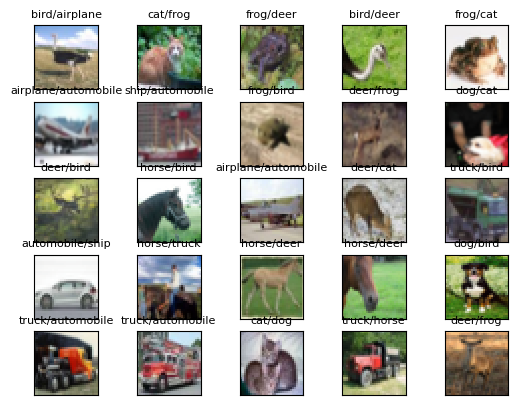

In [8]:
from utils.utils import get_incorrect_predictions
from utils.vis_utils import show_incorrect_predictions
incorrect_predictions = get_incorrect_predictions(model, test_loader, device)
show_incorrect_predictions(incorrect_predictions, class_names, num_rows = 5, num_cols = 5)

In [ ]:
class_names['5']

'dog'

Grad CAM

In [9]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38247 sha256=6f8baae750ab908f4ab0841b2d094e911eada5235da966cfb47f44d491a07f54
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


Define GradCAM

In [18]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
from utils.utils import un_normalize_image

def normalize_image(input_tensor):
    un_norm_image = un_normalize_image(input_tensor.squeeze())
    un_norm_image_np = np.asarray(un_norm_image).astype(np.uint8)
    print(un_norm_image_np.transpose((1,2,0)).shape)
    return un_norm_image_np.transpose((1,2,0))


def generate_grad_cam_visualization(model, target_layers, input_tensor, targets, image_weight=0.2):
    #target_layers = [model.layer4[-1]]
    #input_tensor = input_tensor# Create an input tensor image for your model..
    # Note: input_tensor can be a batch tensor with several images!

    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

    # You can also use it within a with statement, to make sure it is freed,
    # In case you need to re-create it inside an outer loop:
    # with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
    #   ...

    # We have to specify the target we want to generate
    # the Class Activation Maps for.
    # If targets is None, the highest scoring category
    # will be used for every image in the batch.
    # Here we use ClassifierOutputTarget, but you can define your own custom targets
    # That are, for example, combinations of categories, or specific outputs in a non standard model.

    #targets = [ClassifierOutputTarget(281)]

    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    #print(np.max(np.asarray(input_tensor.squeeze())))
    #print(np.min(np.asarray(input_tensor.squeeze())))
    visualization = show_cam_on_image(normalize_image(input_tensor), grayscale_cam, use_rgb=True, image_weight = image_weight)
    return visualization

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


<ipython-input-19-fab6d5c15b86>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(num_rows,num_cols,cnt+1)


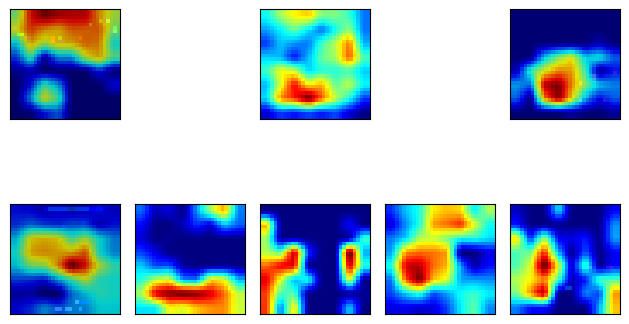

In [19]:
import matplotlib.pyplot as plt
num_grad_cam_images = 10
grad_cam_map_list = []
target_layers = [model.layer3[-1]]
targets = None #[incorrect_predictions[0][2]]

for cnt in range(num_grad_cam_images):
    input_tensor = torch.unsqueeze(incorrect_predictions[cnt][0],0)
    grad_cam_map = generate_grad_cam_visualization(model, target_layers, input_tensor, targets, image_weight=0.2)
    grad_cam_map_list.append(grad_cam_map)

num_rows = 2
num_cols = 5
for cnt in range(num_grad_cam_images):
    plt.subplot(num_rows,num_cols,cnt+1)
    plt.tight_layout()
    plt.imshow(grad_cam_map_list[cnt])
    #title_str = f"{class_names[str(target_label.item())]}/{class_names[str(predicted_label.item())]}"
    #plt.title(title_str)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

def un_normalize_image(img):
    un_norm_transform = transforms.Compose([transforms.Normalize((0.,0.,0.,),(1./0.247,1./0.244,1./0.262)),
                                                 transforms.Normalize((-0.491,-0.482,-0.447),(1.0,1.0,1.0))])
    return un_norm_transform(img)

def preview_augmentations(train_loader, image_transform):
    batch_data, batch_label = next(iter(train_loader))
    preview_img = np.asarray(un_normalize_image(batch_data[0].squeeze()))
    preview_img = (preview_img*255./np.max(preview_img)).astype('uint8')
    preview_label = batch_label[0]
    fig, axs = plt.subplots(1, 2)
    plt.tight_layout()

    un_normalized_img = un_normalize_image(batch_data[0].squeeze())
    un_normalized_img = np.asarray(un_normalized_img)
    transformed_numpy_img = image_transform(image = un_normalized_img.transpose(1,2,0))["image"]
    axs[0].imshow(preview_img.transpose((1,2,0)))
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].imshow(transformed_numpy_img)
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    plt.tight_layout()
    plt.show()

# Reload train and test loader to preview augmentations
torch.manual_seed(1)
batch_size = 512
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
eg_train_loader, eg_test_loader, eg_class_names = load_cifar10_data(train_transforms= A.Compose([A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),ToTensorV2()]), test_transforms=A.Compose([A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),ToTensorV2()]), batch_size=32, **kwargs)

# Random Resized Crop
img_transforms = A.Compose([AA.crops.transforms.RandomResizedCrop(height= 32,width = 32,p=0.2)])
preview_augmentations(eg_train_loader, img_transforms)

# Horizontal Flip
img_transforms = A.Compose([A.HorizontalFlip(always_apply=True)])
preview_augmentations(eg_train_loader, img_transforms)

# Cut out
img_transforms = A.Compose([AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1, max_height=8,
                                                max_width=8, min_holes = 1,
                                                min_height=8, min_width=8,
                                                fill_value=(0.491, 0.482, 0.447),
                                                mask_fill_value = None, always_apply=True)])
preview_augmentations(eg_train_loader, img_transforms)



Show sample Images from the dataset

In [ ]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

Train model using Batch Normalization

In [ ]:
drop_out = 0.02
num_epochs=24
resnet_model = CustomResnet(base_channels=3, num_classes=10,drop_out_probability=drop_out).to(device)
criterion = nn.CrossEntropyLoss(reduction='mean')
optim_obj = Optimization(resnet_model, device, train_loader, criterion, num_epochs)
lr_history = find_best_lr(resnet_model, train_loader, optim_obj.optimizer, criterion, device)


In [ ]:
from torch.optim.lr_scheduler import OneCycleLR
#optim_obj.define_scheduler(max_lr=4.93E-2)
train_losses = []
test_losses = []
train_acc = []
test_acc = []
lr_values = []
def define_scheduler(max_lr):
    scheduler = OneCycleLR(
        optim_obj.optimizer,
        max_lr = max_lr,
        steps_per_epoch=len(optim_obj.train_loader),
        epochs = num_epochs,
        pct_start = 5./num_epochs,
        div_factor=2000,
        three_phase=False,
        final_div_factor= 100,
        anneal_strategy='linear',
        verbose=False
        )
    return scheduler

max_lr = 4.65e-2
optim_obj.scheduler = define_scheduler(max_lr)

for epoch in range(1,num_epochs+1):
    lr_values.append(optim_obj.scheduler.get_lr())
    print(f"epoch: {epoch}\t learning rate: {optim_obj.scheduler.get_last_lr()[0]}")
    this_train_loss = training_loop(resnet_model, device, train_loader, optim_obj.optimizer, optim_obj.scheduler, criterion, train_acc, train_losses)
    this_loss = model_test(resnet_model, device, test_loader, criterion, test_acc, test_losses)
    #optim_obj.scheduler.step()



Plot LR values

In [ ]:
import matplotlib.pyplot as plt
def plot_lr_values2(lr_list):
    num_epochs = len(lr_list)
    plt.figure()
    plt.plot(range(1,num_epochs+1),lr_list)
    plt.xlabel('Epoch #')
    plt.ylabel("Learning Rate")
    #plt.yscale('log')
    plt.show()

def plot_lr_values(scheduler, num_epochs, num_batches):
    lrs = []
    steps = []
    for epoch in range(num_epochs):
        for batch in range(num_batches):
            scheduler.step()
            lrs.append(scheduler.get_last_lr()[0])
            steps.append(epoch * num_batches + batch)

    plt.figure()
    plt.legend()
    plt.plot(steps, lrs, label='OneCycle')
    plt.show()

def plot_losses(train_losses, test_losses):
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    epochs = range(1,len(train_losses)+1)
    axs[0].plot(epochs, train_losses)
    axs[0].set_title("Train")
    axs[1].plot(epochs, test_losses)
    axs[1].set_title("Test")

def plot_accuracy(train_acc, test_acc, target_test_acc = 90.):
    epochs = range(1,len(train_acc)+1)
    plt.figure()
    plt.plot(epochs, train_acc, epochs, test_acc)
    plt.axhline(target_test_acc, color='r')
    plt.legend(('Train','Test'),loc='best')
    plt.title("Accuracy")


Plot results for Batch Norm experiment

In [ ]:
this_scheduler = OneCycleLR(
        optim_obj.optimizer,
        max_lr = max_lr,
        steps_per_epoch=len(optim_obj.train_loader),
        epochs = num_epochs,
        pct_start = 5./num_epochs,
        div_factor=200,
        three_phase=False,
        #final_div_factor=1000,
        anneal_strategy='linear',
        verbose=False
        )
plot_lr_values(this_scheduler, num_epochs, len(train_loader))
plot_losses(train_losses, test_losses)
plot_accuracy(train_acc, test_acc, target_test_acc=90.)


Print Training Log

In [ ]:
print_train_log(train_acc, test_acc, train_losses, test_losses)